In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import re
%matplotlib inline

In [27]:
# df_orders = spark.read.csv('/home/gwq/5003/cleaned_orders.csv',header=True, inferSchema=True, sep=',')
# df_vendor = spark.read.csv('/home/gwq/5003/cleaned_vendors.csv',header=True, inferSchema=True, sep=',')
df_customer = spark.read.csv('/home/gwq/5003/cleaned_train_customer.csv',header=True, inferSchema=True, sep=',')
# df_customer_location = spark.read.csv('/home/gwq/5003/cleaned_train_locations.csv',header=True, inferSchema=True, sep=',')


## **vendors**

In [48]:
df_vendor=df_vendor.select('*').withColumnRenamed('id','vendor_id')

In [85]:
# df_vendor.columns

In [5]:
df_vendor_category = df_vendor.groupby('vendor_category_en')\
                     .count()\
                    .withColumnRenamed('vendor_category_en', 'category')\
                    .withColumnRenamed('count', 'number')

In [10]:
df_vendor_category=df_vendor_category.toPandas()
# df_vendor_category

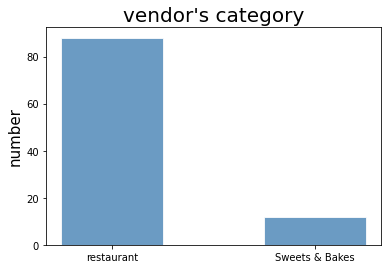

In [17]:
plt.bar(['restaurant','Sweets & Bakes'],df_vendor_category.number,alpha=0.8,width=0.5,color='steelblue',edgecolor='white')
plt.title("vendor's category", fontsize=20)
plt.ylabel('number', fontsize=15)

plt.show()

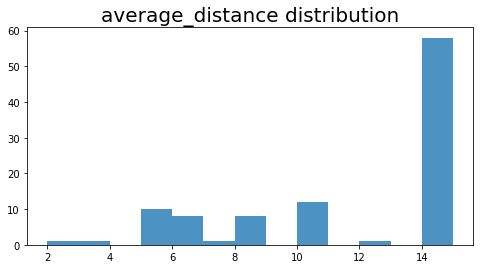

In [22]:
df_vendor_dis = df_vendor.select('serving_distance').toPandas()
df_vendor_dis
plt.figure(figsize=(8, 4))
plt.hist(df_vendor_dis['serving_distance'],bins=13,alpha=0.8)
plt.title("average_distance distribution", fontsize=20)
plt.show()

In [23]:
df_vendor_distance = df_vendor.select('serving_distance','vendor_category_en')\
                    .groupby('vendor_category_en').avg('serving_distance')\
                    .withColumnRenamed('avg(serving_distance)', 'avg_ser_dis').toPandas()

In [24]:
df_vendor_distance

,vendor_category_en,avg_ser_dis
0,1,11.590909
1,2,12.916667


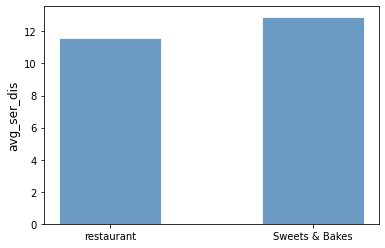

In [26]:
plt.bar(['restaurant','Sweets & Bakes'],df_vendor_distance.avg_ser_dis,alpha=0.8,width=0.5,color='steelblue',edgecolor='white')
# plt.title("vendor's average service distance", fontsize=18)
plt.ylabel('avg_ser_dis', fontsize=12)

plt.show()

In [28]:
df_pre_time = df_vendor.select('prepration_time').toPandas()

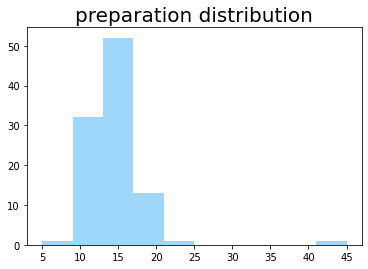

In [29]:
plt.hist(df_pre_time['prepration_time'],color='#87CEFA',alpha=0.8)
plt.title("preparation distribution", fontsize=20)
plt.show()

In [30]:
df_vendor_pretime = df_vendor.select('prepration_time','vendor_category_en')\
                            .groupby('vendor_category_en').avg('prepration_time')\
                            .withColumnRenamed('avg(prepration_time)', 'avg_pretime').toPandas()

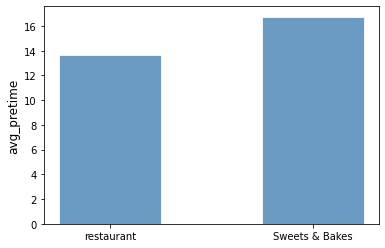

In [34]:
plt.bar(['restaurant','Sweets & Bakes'],df_vendor_pretime.avg_pretime,alpha=0.8,width=0.5,color='steelblue',edgecolor='white')
# plt.title("vendor's average preparation time ", fontsize=18)
plt.ylabel('avg_pretime', fontsize=12)

plt.show()

In [36]:
df_rating_pretime = df_vendor.select('vendor_rating','prepration_time').distinct().toPandas()

In [38]:
df_rating = df_vendor.select('vendor_rating').toPandas()

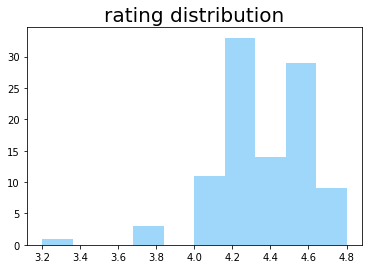

In [39]:
plt.hist(df_rating['vendor_rating'],color='#87CEFA',alpha=0.8)
plt.title("rating distribution", fontsize=20)
plt.show()

Text(0.5, 0, 'rating')

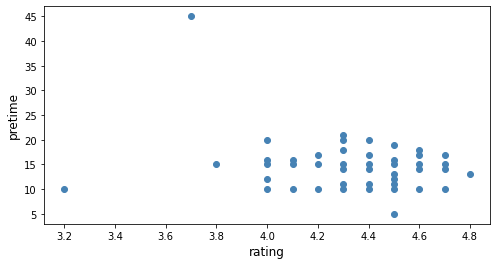

In [41]:
plt.figure(figsize=(8, 4))
plt.scatter(df_rating_pretime.vendor_rating,df_rating_pretime.prepration_time,alpha=1,color='steelblue')
# plt.title("relationship between rating and  preparatime", fontsize=18)
plt.ylabel('pretime', fontsize=12)
plt.xlabel('rating', fontsize=12)

# **customer**

In [10]:
df_customer=df_customer.select('*').withColumnRenamed('akeed_customer_id','customer_id')

In [24]:
df_customer['gender'].fillna(0, inplace=True)

TypeError: 'Column' object is not callable

In [11]:
df_customer.columns

['_c0',
 'customer_id',
 'gender',
 'dob',
 'status_customer',
 'verified_customer',
 'language_customer']

In [28]:
df_customer_gender = df_customer.dropna().groupby('gender').count().\
                    withColumnRenamed('count','number').toPandas()

In [29]:
# df_customer_gender.loc['gender']= 1
df_customer_gender

,gender,number
0,0.0,12154
1,1.0,20738
2,2.0,1779


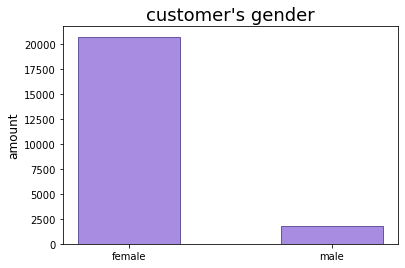

In [33]:
plt.bar(['female','male'],df_customer_gender.number[1:],alpha=0.8,width=0.5,color='mediumpurple',edgecolor='darkslateblue')
plt.title("customer's gender", fontsize=18)
plt.ylabel('amount', fontsize=12)

plt.show()

In [34]:
def calc_age(year):
    if len(str(year))==2:
        if str(year).startswith('0'):
            year = '20'+str(year)
        else:
            year = '19'+str(year)
        year = int(year)
    if year is None:
        return np.nan
    return 2020-year
df = df_customer.toPandas()
df.loc[:, 'age'] = df['dob'].apply(calc_age)
# df_customer[customers['age']<16]

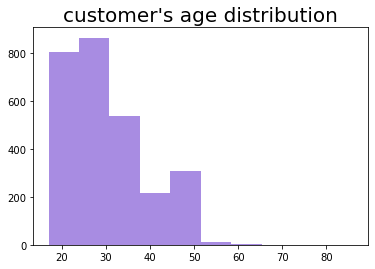

In [35]:
cc=df.values.tolist()

dd=list(df.columns)
df_customer = spark.createDataFrame(cc, dd)
df_age = df_customer.select('age').filter('age>16').filter('age<110').toPandas()
# df_age['age'].unique()
# ages = df[df['age']>16]
# ages = ages[ages['age']<110]
plt.hist(df_age['age'].dropna(),color='mediumpurple',alpha=0.8)
plt.title("customer's age distribution", fontsize=20)
plt.show()

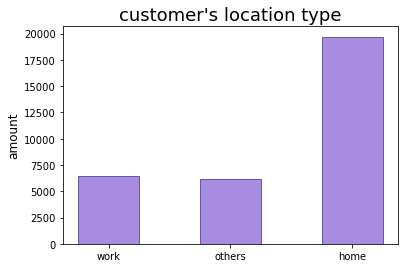

In [50]:
df_lotp = df_customer_location.groupby('location_type').count().\
        withColumnRenamed('count','number').toPandas()
plt.bar(['work','others','home'],df_lotp.number[:-1],alpha=0.8,width=0.5,color='mediumpurple',edgecolor='darkslateblue')
plt.title("customer's location type", fontsize=18)
plt.ylabel('amount', fontsize=12)

plt.show()

In [51]:
df_locs=df_customer_location.toPandas()

In [52]:
def check_num(string):
    regex = r'-?[0-9]*.[0-9]*'
    m = re.match(regex, string)
    if m is None:
        return float(0)
    return float(string[:6])

# df_locs['latitude'] = df_locs['latitude'].apply(check_num)
# df_locs['longitude'] = df_locs['longitude'].apply(check_num)
# df_locs['geometry'] = gpd.points_from_xy(df_locs['longitude'], df_locs['latitude'])

In [54]:
# df_locs.dropna()
# m = folium.Map(location=[50,-85], zoom_start=2)
# for i in list(df_locs.index)[:200]:
#     folium.Marker([df_locs.loc[i, 'latitude'], df_locs.loc[i, 'longitude']]).add_to(m)
# m

# orders

In [45]:
df_orders.columns

['_c0',
 'akeed_order_id',
 'customer_id',
 'item_count',
 'grand_total',
 'payment_mode',
 'promo_code',
 'vendor_discount_amount',
 'promo_code_discount_percentage',
 'is_favorite',
 'is_rated',
 'vendor_rating',
 'driver_rating',
 'deliverydistance',
 'preparationtime',
 'delivery_time',
 'order_accepted_time',
 'driver_accepted_time',
 'ready_for_pickup_time',
 'picked_up_time',
 'delivered_time',
 'delivery_date',
 'vendor_id',
 'created_at',
 'LOCATION_NUMBER',
 'LOCATION_TYPE',
 'CID X LOC_NUM X VENDOR']

In [50]:
df_orders.groupby('vendor_id').count()\
        .withColumnRenamed('count','amount')\
        .join(df_vendor.select('vendor_id','prepration_time','vendor_category_en',
                               'serving_distance','delivery_charge','vendor_rating'),
              'vendor_id','left_outer')\
        .orderBy('amount', ascending=False)\
        .show()

+---------+------+---------------+------------------+----------------+---------------+-------------+
|vendor_id|amount|prepration_time|vendor_category_en|serving_distance|delivery_charge|vendor_rating|
+---------+------+---------------+------------------+----------------+---------------+-------------+
|      113|  7456|             10|                 1|            15.0|            0.0|          4.7|
|      105|  5217|             12|                 1|            15.0|            0.0|          4.5|
|       79|  5065|             15|                 1|            15.0|            0.0|          4.7|
|       84|  4951|             14|                 1|            15.0|            0.0|          4.3|
|       78|  3914|             17|                 1|            15.0|            0.7|          4.4|
|      386|  3260|             15|                 2|            15.0|            0.0|          4.5|
|       83|  3074|             15|                 1|            15.0|            0.7|     

In [53]:
df1=df_orders.groupby('customer_id').count()\
        .withColumnRenamed('count','amount')\
        .join(df_customer.select('gender','customer_id'),'customer_id','left_outer')\
        .orderBy('amount',ascending=False)

In [65]:
df2=df_orders.select('customer_id','item_count','grand_total',).groupby('customer_id').avg('grand_total','item_count')\
        .withColumnRenamed('avg(item_count)','avg_item')\
        .withColumnRenamed('avg(grand_total)','avg_total')\
        .orderBy('avg_total','avg_item',ascending=False)

In [68]:
df1.join(df2,'customer_id','inner').orderBy('avg_total','amount','avg_item',ascending=False).show()


+-----------+------+------+------------------+--------+
|customer_id|amount|gender|         avg_total|avg_item|
+-----------+------+------+------------------+--------+
|    HPERFQJ|     1|   1.0|             783.8|    68.0|
|    AAJY8DZ|     1|   0.0|             212.0|    14.0|
|    L4Y9P84|     1|   2.0|             169.7|     4.0|
|    J2CLYW5|     1|   0.0|             143.5|     3.0|
|    8ML124D|     1|   1.0|             138.6|    18.0|
|    PUUEW3U|     1|   1.0|             136.6|     6.0|
|    O1UCOD0|     1|   0.0|             134.3|     4.0|
|    OT5DK5L|     1|   2.0|             134.0|    17.0|
|    C31LYDS|     1|  null|             130.3|     3.0|
|    AN7TY2S|     1|   1.0|             130.3|     3.0|
|    21J0Y23|     1|   1.0|             124.9|    11.0|
|    JCO5OEF|     1|   2.0|             122.1|     9.0|
|    SJR7X1I|     1|   0.0|             117.0|     2.0|
|    SSCNNOX|     1|   0.0|             116.0|     3.0|
|    37SO8LJ|     2|   2.0|114.39999999999999|  

In [112]:
df1.join(df2,'customer_id','inner').orderBy('amount','avg_total','avg_item',ascending=False).show()

+-----------+------+------+------------------+------------------+
|customer_id|amount|gender|         avg_total|          avg_item|
+-----------+------+------+------------------+------------------+
|    XW90EAP|   247|   1.0|14.392307692307671|2.1781376518218623|
|    VDEJEMP|   143|   1.0|13.979020979020975| 2.062937062937063|
|    TL7Z2DM|   139|   1.0|10.892805755395694| 2.446043165467626|
|    HJFTTGW|   121|   0.0|12.450413223140503|2.3057851239669422|
|    B28LJKM|   117|   1.0| 33.28717948717948|4.0085470085470085|
|    2JJAO46|   110|  null|18.607272727272726|2.6363636363636362|
|    TVSPG2H|   110|   1.0|12.516363636363632|               2.8|
|    KXXRD9J|   106|   1.0|13.553773584905652|2.1037735849056602|
|    HX76ORD|   101|   2.0|14.509900990099021| 1.900990099009901|
|    BUIAFFT|   100|   1.0|            22.388|              2.54|
|    8771JHK|    96|   1.0|22.029166666666658|3.1354166666666665|
|    1P5RQ9H|    96|   1.0|18.703124999999996|2.4583333333333335|
|    X8BK4

In [3]:
# df_orders.select('payment_mode').show()

In [24]:
# df_orders.select('delivered_time'-'order_accepted_time').show()

In [4]:
df1 = df_orders.groupby('customer_id','vendor_id').count()\
            .withColumnRenamed('count','order_times')\
            .filter('order_times>1')\
            .orderBy('customer_id')

In [5]:
cu_ven = df_orders.groupby('customer_id','vendor_id').count()\
            .withColumnRenamed('count','order_times')\
            .orderBy('customer_id').count()

In [35]:
print('Repurchase rate:',df1.count()/cu_ven*100,"%")

Repurchase rate: 33.14659061144903 %


In [6]:
df1.show()

+-----------+---------+-----------+
|customer_id|vendor_id|order_times|
+-----------+---------+-----------+
|    005ECL6|      237|          2|
|    00HRRAK|      298|          4|
|    00NAL8D|      583|          4|
|    00OT8JX|      192|          2|
|    00OT8JX|        4|         21|
|    00OT8JX|      298|          2|
|    00OT8JX|       92|          2|
|    00OT8JX|      159|          9|
|    00OT8JX|      104|          2|
|    00U89UY|       79|          2|
|    010DVV3|       84|          2|
|    018GT0H|       33|          2|
|    018GT0H|      106|          2|
|    0198LZL|      845|          2|
|    01BY7WQ|      356|          2|
|    01BY7WQ|      145|          3|
|    01HG648|      419|          2|
|    01HG648|      537|          6|
|    01HG648|       84|          3|
|    01QRJWD|      401|          3|
+-----------+---------+-----------+
only showing top 20 rows



In [14]:
df2 = df1.groupby('order_times').count()\
        .withColumnRenamed('count','amount')\
        .orderBy('count',ascending=False)
df_p = df2.select('order_times',df2.amount/cu_ven*100).withColumnRenamed('((amount / 68722) * 100)','percentage')
df_9 = df_p.select('percentage','order_times').filter('order_times>8').groupby().sum('percentage').collect()[0].asDict()['sum(percentage)']
df_p = df_p.filter('order_times<=8').toPandas()
df_p = df_p.append([{'order_times':'more than 9','percentage':df_9}], ignore_index=True)

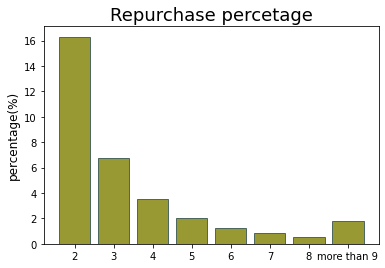

In [42]:
x=df_p['order_times']
y=df_p['percentage']
plt.bar(x,y,alpha=0.8,color='olive',edgecolor='darkslategray')
plt.title("Repurchase percetage", fontsize=18)
plt.ylabel('percentage(%)', fontsize=12)

plt.show()